In [1]:
import random
import numpy as np
from matplotlib import pyplot as plt
import itertools
import json

"""
A simple simulator for Oxford Nanopore current signals.

Support for:

0. Arbitrary kmer lengths
1. User defined signal noise (default is gaussian)
2. User defined dwell-time distribution (default is poisson)
3. Sensible defaults

Example usage:

>>> sequence = simulate_dna_sequence(200)
>>> pore_model = Pore(kmer_len=5)
>>> signal = pore_model.get_squiggle(sequence)
>>> plt.plot(signal)
>>> plt.show()
"""

ALPHABET = "ACGT"
NUCLEOTIDE_ORDER = {"A": 0, "C": 1, "G": 2, "T": 3}

DWELL = {
    'fixed':   lambda mean_dwell: mean_dwell,
    'normal':  lambda mean_dwell: max(0, int(np.round(np.random.normal(mean_dwell)))),
    'gamma':   lambda mean_dwell: int(np.round(np.random.gamma(2.0, mean_dwell / 2))),
    'poisson': lambda mean_dwell: np.random.poisson(mean_dwell),
}

NOISE = {
    'clean':  lambda signal, amp=0.00: np.zeros(len(signal)),
    'normal': lambda signal, amp=0.05: np.random.normal(0, amp, len(signal))
}


CURRENT_LEVELS = {
    'even_space': lambda kmer_len: list(np.arange(0, 1, 1 / len(ALPHABET) ** kmer_len)),
    'random': lambda kmer_len: [random.random() for _ in range(len(ALPHABET) ** kmer_len)],
    'resistor_model': lambda kmer_len: [serial_resistor_model(k, kmer_len) for k in range(len(ALPHABET) ** kmer_len)]
}


def simulate_dna_sequence(seq_length, alphabet=ALPHABET):
    """
    Generate a random sequence of length `seq_length`.
    """
    return "".join(random.choice(alphabet) for _ in range(seq_length))


def sequence_generator(mean_seq_length, seq_length_distribution_process="normal"):
    """
    Infinite generator of random sequences.
    """
    while True:
        seq_length = DWELL[seq_length_distribution_process](mean_seq_length)
        yield simulate_dna_sequence(seq_length)


def serial_resistor_model(kmer, kmer_len):
    """
    Under this model each nucleotide contributes a fixed serial resistance,
    Hence, kmers ACA, CAA, AAC all have the same level.
    The level is normalised so conductance is always between 0.0 and 1.0.
    """
    conductance = 0.0
    for i in range(kmer_len):
        conductance += float((kmer & 3)) / (len(ALPHABET) - 1)
        kmer = kmer >> 2
    conductance = conductance / kmer_len
    return conductance


class Pore:

    def __init__(
            self, kmer_len=5, mean_dwell_time=10,
            signal_to_noise=250,
            signal_noise_process="normal",
            dwell_distribution_process="poisson",
            current_level_model="random"
    ):
        self.kmer_len = kmer_len
        self.mean_dwell_time = mean_dwell_time
        self.noise_amplitude = 1.0 / signal_to_noise
        self.signal_noise_process = NOISE[signal_noise_process]
        self.dwell_distribution_process = DWELL[dwell_distribution_process]
        self.current_levels = CURRENT_LEVELS[current_level_model](self.kmer_len)

    def _kmer_index(self, kmer):
        lexical_order = NUCLEOTIDE_ORDER[kmer[0]]
        for k in kmer[1:]:
            lexical_order = (lexical_order << 2) + NUCLEOTIDE_ORDER[k]
        return lexical_order
    
    def kmer_table(self):
        labels = ["".join(s) for s in itertools.product('ACGT', repeat=self.kmer_len)]
        return (dict(zip(labels, self.current_levels)))
        
    def generate_signal(self, dna_sequence, return_alignment=False):
        signal = []
        alignment = [0, ]
        for i in range(len(dna_sequence) - self.kmer_len + 1):
            kmer = dna_sequence[i: i + self.kmer_len]
            kmer_index = self._kmer_index(kmer)
            dwell_time = self.dwell_distribution_process(self.mean_dwell_time)
            for _ in range(dwell_time):
                signal.append(self.current_levels[kmer_index])
            alignment.append(max(0, len(signal) - 1))

        noise = self.signal_noise_process(signal, amp=self.noise_amplitude)

        if return_alignment:
            return np.array(signal) + noise, np.array(alignment)
        return np.array(signal) + noise


def simulator(seq_length, pore, seq_length_distribution="normal", chunksize=None):
    """
    Infinite generator of `sequence, signal, alignment`.
    """
    for sequence in sequence_generator(seq_length, seq_length_distribution):

        signal, alignment = pore.generate_signal(sequence, return_alignment=True)

        if chunksize and alignment[-1] < chunksize:
            print('sequence too short')
            continue

        if chunksize:
            pos = np.searchsorted(alignment, chunksize)
            yield sequence[:pos], signal[:chunksize], alignment[:pos]
        else:
            yield sequence, signal, alignment



In [2]:
np.random.seed(1)

## Make a pore object

In [3]:
pore = Pore(kmer_len=2,
           current_level_model="even_space")

## Let's generate the kmer table

In [4]:
kmer_table = pore.kmer_table()

In [5]:
with open('kmer_table.json', 'w') as kmer_table_file:
     kmer_table_file.write(json.dumps(kmer_table))

## Now let's generate some signals

In [6]:
num_signals = 1000

In [7]:
signals = []
sequences = []

for i in range(200):
    result = next(simulator(200, pore, chunksize=1000))
    sequences.append(result[0])
    signals.append(result[1].tolist())

with open('signals.json', 'w') as signals_file:
    signals_file.write(json.dumps(signals))
    
with open('sequences.json', 'w') as sequences_file:
    sequences_file.write(json.dumps(sequences))

## Plot kmer levels

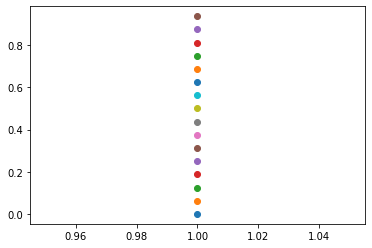

In [8]:
for value in kmer_table.values():
    plt.plot(1,value,marker='o')

## Plot an example of a signal

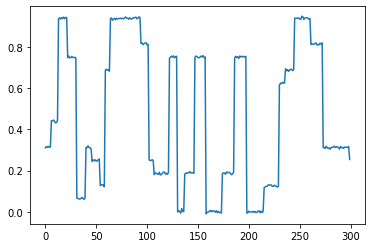

In [9]:
plt.plot(signals[0][:300])